In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing
import sklearn.decomposition
import sklearn.model_selection
import sklearn.svm
import sklearn.inspection
import sklearn.feature_selection
from sklearn.experimental import enable_halving_search_cv

In [5]:
import sklearn.pipeline
import sklearn.ensemble

In [2]:
df = pd.read_csv('npf_train.csv')

class2 = np.array(["event"]*df.shape[0],dtype="object")
class2[df["class4"]=="nonevent"] = "nonevent"
df["class2"] = class2
df["class2"] = df["class2"].astype("category")

not_needed_columns = ["partlybad", "id", "date"]
df = df.drop(not_needed_columns, axis=1)

class2_categories = {
    "nonevent": 0,
    "event": 1
}

class4_categories = {
    "nonevent": 0,
    "Ia": 1,
    "Ib": 2,
    "II": 3
}

def categorize_class2(row):
    row["class2"] = class2_categories[row["class2"]]
    
    return row
def categorize_class4(row):
    row["class4"] = class4_categories[row["class4"]]
    
    return row

df = df.apply(lambda row: categorize_class2(row), axis=1)
df = df.apply(lambda row: categorize_class4(row), axis=1)
df["class2"] = df["class2"].astype("category")
df["class4"] = df["class4"].astype("category")

In [3]:
X_df = df.loc[:, ~df.columns.isin(['class2', 'class4'])].copy()
Y_2 = df['class2'].copy()
Y_4 = df['class4'].copy()

X = X_df.values
y_2 = Y_2.values
y_4 = Y_4.values

In [164]:
# Feature selection using Recursive feature elimination with cross-validation

def feature_selection_RFE(X, y):
    pipeline_rfe = sklearn.pipeline.Pipeline(
                        [('scaler', sklearn.preprocessing.StandardScaler()), 
                        ('feature_selection', sklearn.feature_selection.RFECV(
                                                estimator=sklearn.svm.LinearSVC(penalty="l1", C=0.75, 
                                                max_iter=10**5, dual=False, random_state=0), n_jobs=6,
                                                step=1, cv=10, scoring="accuracy", min_features_to_select=1))]
    )
    
    pipeline_rfe.fit(X, y)
    return pipeline_rfe

def feature_selection_RFE_RFC(X, y):
    pipeline = sklearn.pipeline.Pipeline(
                        [('scaler', sklearn.preprocessing.StandardScaler()), 
                        ('feature_selection', sklearn.feature_selection.RFECV(
                                                estimator=sklearn.ensemble.RandomForestClassifier(
                                                    n_estimators=200, random_state=0), n_jobs=6,
                                                step=1, cv=10, scoring="accuracy", min_features_to_select=1))]
    )
    
    pipeline.fit(X, y)
    return pipeline

def plot_feature_importance(pipeline_rfe):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x=range(1, len(pipeline_rfe[1].cv_results_['mean_test_score'])+1), 
                 y=pipeline_rfe[1].cv_results_['mean_test_score'], label='LinearSVC', ax=ax)
    ax.set_xlabel('Number of features selected')
    ax.set_ylabel('Cross validation score (accuracy)')
    ax.axvline(x=np.argmax(pipeline_rfe[1].cv_results_['mean_test_score'])+1, c='r')
    plt.show()
    
    print('Best number of features: ', np.argmax(pipeline_rfe[1].cv_results_['mean_test_score'])+1)
    
    return fig, ax

In [145]:
# Feature selection using Permutation importance score

def feature_selection_PI(estimator, X, y, th):
    
    estimator.fit(X, y)

    feature_importance_search = sklearn.inspection.permutation_importance(
                                estimator, X, y, n_repeats=100, n_jobs=4)
    
    fig, ax = plt.subplots(figsize=(20, 6))
    ax = sns.scatterplot(x=X_df.columns, y=feature_importance_search.importances_mean, ax=ax)
    ax.tick_params(axis='x', labelrotation=90)
    ax.axhline(th, c='r', ls=':')
    ax.axhline(-th, c='r', ls=':')
    plt.show()

    selected_features_pi = X_df.columns[np.where(np.abs(feature_importance_search.importances_mean) > th)]
    selected_features_idx_pi = np.where(np.abs(feature_importance_search.importances_mean) > th)[0]
    
    return feature_importance_search, selected_features_pi, selected_features_idx_pi

In [74]:
# Selected classifier: RandomForestClassifier

def predictor_RFC(X, y):
    pipeline_rf = sklearn.pipeline.Pipeline(
                    [('scaler', sklearn.preprocessing.StandardScaler()), 
                     #("feature_selection", sklearn.feature_selection.RFECV(
                     #                        estimator=sklearn.svm.LinearSVC(penalty="l1", C=0.75, max_iter=10**5,
                     #                                                        dual=False, random_state=0), 
                     #                        cv=10, scoring="accuracy")), 
                     ('clf', sklearn.ensemble.RandomForestClassifier(random_state=0))]
        )
    
    param_grid = {'clf__n_estimators':np.arange(10, 210, 10), 'clf__criterion':['gini', 'entropy']}
    param_search = sklearn.model_selection.HalvingGridSearchCV(pipeline_rf, param_grid, cv=10, n_jobs=4)
    
    param_search.fit(X, y)
    
    print('Best RFC model: ', param_search.best_params_, param_search.best_score_)
    
    best_n_estimators = param_search.best_params_['clf__n_estimators']
    best_criterion = param_search.best_params_['clf__criterion']
    
    pipeline_rf_best = sklearn.pipeline.Pipeline(
                        [('scaler', sklearn.preprocessing.StandardScaler()), 
                         ('clf', sklearn.ensemble.RandomForestClassifier(n_estimators=best_n_estimators, 
                                                                         criterion=best_criterion, 
                                                                         random_state=0))]
        )

    cv_scores = sklearn.model_selection.cross_val_score(pipeline_rf_best, X, y, cv=10)
    
    print('Prediction accuracy: ', np.mean(cv_scores))
    
    return param_search, pipeline_rf_best, cv_scores

In [151]:
# Selected classifier: GradientBoostingClassifier

def predictor_GBC(X, y):
    pipeline = sklearn.pipeline.Pipeline(
                    [('scaler', sklearn.preprocessing.StandardScaler()), 
                     #("feature_selection", sklearn.feature_selection.RFECV(
                     #                        estimator=sklearn.svm.LinearSVC(penalty="l1", C=0.75, max_iter=10**5,
                     #                                                        dual=False, random_state=0), 
                     #                        cv=10, scoring="accuracy")), 
                     ('clf', sklearn.ensemble.GradientBoostingClassifier(random_state=0))]
        )
    
    param_grid = {'clf__n_estimators':np.arange(20, 410, 20), 'clf__learning_rate':[0.0001, 0.001, 0.1, 1, 10]}
    param_search = sklearn.model_selection.HalvingGridSearchCV(pipeline, param_grid, cv=10, n_jobs=4)
    
    param_search.fit(X, y)
    
    print('Best GBC model: ', param_search.best_params_, param_search.best_score_)
    
    best_n_estimators = param_search.best_params_['clf__n_estimators']
    best_learning_rate = param_search.best_params_['clf__learning_rate']
    
    pipeline_best = sklearn.pipeline.Pipeline(
                        [('scaler', sklearn.preprocessing.StandardScaler()), 
                         ('clf', sklearn.ensemble.GradientBoostingClassifier(n_estimators=best_n_estimators, 
                                                                         learning_rate=best_learning_rate, 
                                                                         random_state=0))]
        )

    cv_scores = sklearn.model_selection.cross_val_score(pipeline_best, X, y, cv=10)
    
    print('Prediction accuracy: ', np.mean(cv_scores))
    
    return param_search, pipeline_best, cv_scores

In [166]:
# Selected classifier: SVC

def predictor_SVC(X, y):
    pipeline = sklearn.pipeline.Pipeline(
                    [('scaler', sklearn.preprocessing.StandardScaler()), 
                     #("feature_selection", sklearn.feature_selection.RFECV(
                     #                        estimator=sklearn.svm.LinearSVC(penalty="l1", C=0.75, max_iter=10**5,
                     #                                                        dual=False, random_state=0), 
                     #                        cv=10, scoring="accuracy")), 
                     ('clf', sklearn.svm.SVC(random_state=0))]
        )
    
    param_grid = {
                    'clf__C':10.0**np.arange(-5, 6),
                    'clf__kernel':['poly', 'rbf', 'sigmoid'],
                    'clf__degree':np.arange(1, 11),
                    }
    
    param_search = sklearn.model_selection.HalvingGridSearchCV(pipeline, param_grid, cv=10, n_jobs=4)
    
    param_search.fit(X, y)
    
    print('Best SVC model: ', param_search.best_params_, param_search.best_score_)
    
    best_C = param_search.best_params_['clf__C']
    best_kernel = param_search.best_params_['clf__kernel']
    best_degree = param_search.best_params_['clf__degree']
    
    pipeline_best = sklearn.pipeline.Pipeline(
                        [('scaler', sklearn.preprocessing.StandardScaler()), 
                         ('clf', sklearn.svm.SVC(C=best_C, kernel=best_kernel, 
                                                          degree=best_degree, random_state=0))]
        )

    cv_scores = sklearn.model_selection.cross_val_score(pipeline_best, X, y, cv=10)
    
    print('CV prediction accuracy: ', np.mean(cv_scores))
    
    return param_search, pipeline_best, cv_scores

In [155]:
# Selected classifier: SVC + precomputed kernels

def predictor_KSVC(K_dict, y):
    
    result_list = []
    
    for name, K in K_dict.items():
        
        params_C = 10.0**np.arange(-8, 8)
        
        for c in params_C:

            SVC = sklearn.svm.SVC(C=c, kernel='precomputed', random_state=0)
            
            SKFold = sklearn.model_selection.StratifiedKFold(n_splits=10, random_state=None)
            cv_acc = []
            for idx_train, idx_test in SKFold.split(X, y):
                K_train, K_test = K[idx_train, :][:, idx_train], K[idx_test, :][:, idx_train]
                y_train, y_test = y[idx_train], y[idx_test]

                SVC.fit(K_train, y_train)
                cv_acc.append(SVC.score(K_test, y_test))
                result_list.append([name, c, np.mean(cv_acc)])
            
    result_df = pd.DataFrame(result_list, columns=['Kernel', 'C', 'CV accuracy'])
    
    return result_df

## class 2 training

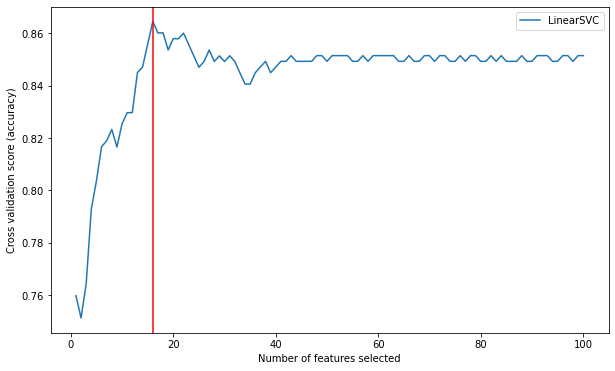

Best number of features:  16


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='Number of features selected', ylabel='Cross validation score (accuracy)'>)

In [75]:
pipeline_rfe_c2 = feature_selection_RFE(X, y_2)

plot_feature_importance(pipeline_rfe_c2)

In [76]:
# Selected features

selected_features_rfe_c2 = pipeline_rfe_c2.get_feature_names_out(X_df.columns)
selected_features_idx_rfe_c2 = np.array([list(X_df.columns).index(i) for i in selected_features_rfe_c2])

print('Selected features: ', selected_features_rfe_c2)

Selected features:  ['CO2336.std' 'H2O336.std' 'H2O42.std' 'H2O504.mean' 'NOx672.mean'
 'O3672.mean' 'PAR.mean' 'PAR.std' 'RHIRGA168.std' 'RHIRGA672.mean'
 'SWS.mean' 'SWS.std' 'T42.std' 'T672.std' 'UV_A.mean' 'CS.mean']


In [77]:
X_selected_c2 = X[:, selected_features_idx_rfe_c2]

In [211]:
param_search_c2, pipeline_rf_best_c2, cv_scores_c2 = predictor_RFC(X_selected_c2, y_2)

Best RFC model:  {'clf__criterion': 'entropy', 'clf__n_estimators': 170} 0.8463492063492064
Prediction accuracy:  0.8601449275362321


In [82]:
# class2 model on class4

cv_scores_c4 = sklearn.model_selection.cross_val_score(pipeline_rf_best_c2, X_selected_c2, y_4, cv=10)
print('class2 model on class4 accuracy: ', np.mean(cv_scores_c4))

class2 model on class4 accuracy:  0.6483091787439613


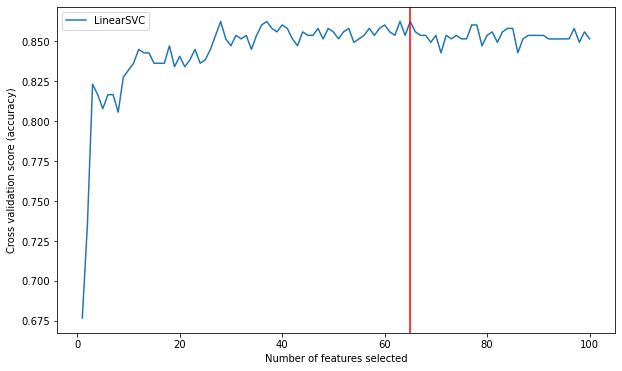

Best number of features:  65
Selected features:  ['CO2168.mean' 'CO2168.std' 'CO2336.mean' 'CO2336.std' 'CO242.mean'
 'CO242.std' 'CO2504.mean' 'CO2504.std' 'Glob.mean' 'H2O168.mean'
 'H2O336.mean' 'H2O42.mean' 'H2O504.mean' 'H2O672.mean' 'H2O84.mean'
 'NET.mean' 'NET.std' 'NO168.mean' 'NO336.mean' 'NO336.std' 'NO504.std'
 'NO672.mean' 'NO672.std' 'NO84.mean' 'NOx168.mean' 'NOx336.mean'
 'NOx42.mean' 'NOx504.mean' 'NOx672.mean' 'NOx84.mean' 'O3168.mean'
 'O342.mean' 'O3504.mean' 'O3672.mean' 'O3672.std' 'O384.mean' 'PAR.mean'
 'RGlob.mean' 'RGlob.std' 'RHIRGA168.mean' 'RHIRGA168.std'
 'RHIRGA336.mean' 'RHIRGA336.std' 'RHIRGA42.mean' 'RHIRGA42.std'
 'RHIRGA504.mean' 'RHIRGA504.std' 'RHIRGA672.mean' 'RHIRGA672.std'
 'RHIRGA84.mean' 'RHIRGA84.std' 'RPAR.mean' 'SO2168.mean' 'SWS.mean'
 'SWS.std' 'T168.mean' 'T42.mean' 'T42.std' 'T504.mean' 'T672.mean'
 'T84.mean' 'T84.std' 'UV_A.mean' 'CS.mean' 'CS.std']
Best RFC model:  {'clf__criterion': 'gini', 'clf__n_estimators': 70} 0.863333333333333

In [180]:
# RFECV (RFC) + RFC CV

pipeline_rfe_rfc_c2 = feature_selection_RFE_RFC(X, y_2)

plot_feature_importance(pipeline_rfe_rfc_c2)

# Selected features

selected_features_rfe_rfc_c2 = pipeline_rfe_rfc_c2.get_feature_names_out(X_df.columns)
selected_features_idx_rfe_rfc_c2 = np.array([list(X_df.columns).index(i) for i in selected_features_rfe_rfc_c2])

print('Selected features: ', selected_features_rfe_rfc_c2)

X_selected_rfc_c2 = X[:, selected_features_idx_rfe_rfc_c2]

param_search_c2_n, pipeline_rf_best_c2_n, cv_scores_c2_n = predictor_RFC(X_selected_rfc_c2, y_2)

## class 4 training 

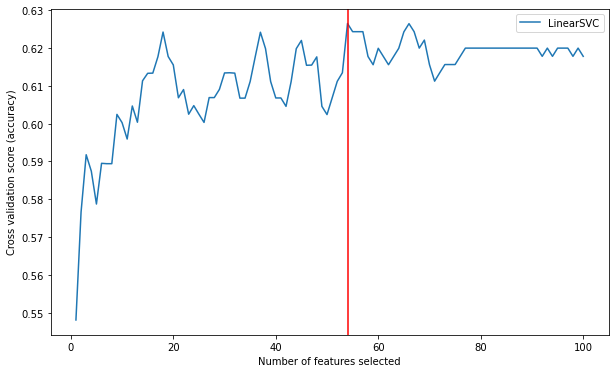

Best number of features:  54


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='Number of features selected', ylabel='Cross validation score (accuracy)'>)

In [83]:
pipeline_rfe_c4 = feature_selection_RFE(X, y_4)

plot_feature_importance(pipeline_rfe_c4)

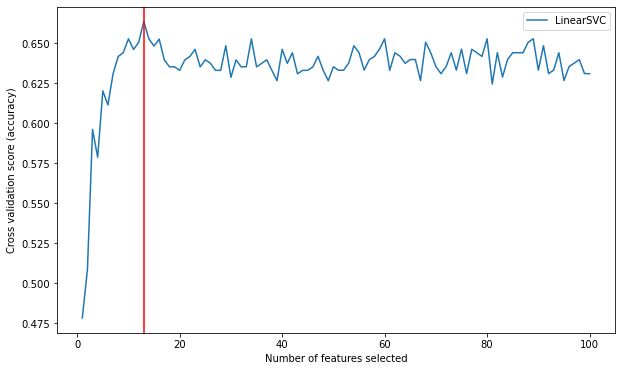

Best number of features:  13


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='Number of features selected', ylabel='Cross validation score (accuracy)'>)

In [165]:
pipeline_rfe_rfc_c4 = feature_selection_RFE_RFC(X, y_4)

plot_feature_importance(pipeline_rfe_rfc_c4)

In [84]:
# Selected features

selected_features_rfe_c4 = pipeline_rfe_c4.get_feature_names_out(X_df.columns)
selected_features_idx_rfe_c4 = np.array([list(X_df.columns).index(i) for i in selected_features_rfe_c4])

print('Selected features: ', selected_features_rfe_c4)

Selected features:  ['CO2168.mean' 'CO2336.std' 'CO242.std' 'CO2504.std' 'Glob.std'
 'H2O168.std' 'H2O336.std' 'H2O42.mean' 'H2O42.std' 'H2O504.mean'
 'H2O672.std' 'NET.std' 'NO168.mean' 'NO168.std' 'NO336.mean' 'NO336.std'
 'NO42.mean' 'NO504.std' 'NO672.mean' 'NO672.std' 'NOx168.std'
 'NOx336.std' 'NOx42.mean' 'NOx672.mean' 'NOx672.std' 'NOx84.std'
 'O342.mean' 'O342.std' 'O3504.std' 'O3672.mean' 'O384.mean' 'O384.std'
 'PAR.mean' 'PAR.std' 'PTG.std' 'RGlob.mean' 'RGlob.std' 'RHIRGA168.std'
 'RHIRGA42.mean' 'RHIRGA42.std' 'RHIRGA672.mean' 'RHIRGA672.std'
 'RPAR.std' 'SO2168.mean' 'SWS.mean' 'SWS.std' 'T42.std' 'T504.std'
 'T672.mean' 'T672.std' 'T84.mean' 'UV_A.mean' 'CS.mean' 'CS.std']


In [179]:
X_selected_c4 = X[:, selected_features_idx_rfe_c4]

param_search_c4, pipeline_rf_best_c4, cv_scores_c4 = predictor_RFC(X_selected_c4, y_4)

Best RFC model:  {'clf__criterion': 'entropy', 'clf__n_estimators': 70} 0.6507246376811595
Prediction accuracy:  0.6440579710144928


In [177]:
# Selected features

selected_features_rfe_rfc_c4 = pipeline_rfe_rfc_c4.get_feature_names_out(X_df.columns)
selected_features_idx_rfe_rfc_c4 = np.array([list(X_df.columns).index(i) for i in selected_features_rfe_rfc_c4])

print('Selected features: ', selected_features_rfe_rfc_c4)

Selected features:  ['H2O42.mean' 'H2O504.mean' 'H2O672.mean' 'NOx42.mean' 'RGlob.mean'
 'RHIRGA168.mean' 'RHIRGA336.mean' 'RHIRGA42.mean' 'RHIRGA42.std'
 'RHIRGA84.mean' 'RHIRGA84.std' 'SWS.mean' 'CS.mean']


In [178]:
X_selected_rfc_c4 = X[:, selected_features_idx_rfe_rfc_c4]

param_search_c4_n, pipeline_rf_best_c4_n, cv_scores_c4_n = predictor_RFC(X_selected_rfc_c4, y_4)

Best RFC model:  {'clf__criterion': 'entropy', 'clf__n_estimators': 150} 0.6471014492753622
Prediction accuracy:  0.6680193236714975


### 2nd way of feature selection and moel traning

In [156]:
param_search_svc_c4, pipeline_svc_c4_best, cv_scores_svc_c4 = predictor_SVC(X, y_4)

Best RFC model:  {'clf__C': 1.0, 'clf__degree': 4, 'clf__kernel': 'rbf'} 0.6088768115942029
Prediction accuracy:  0.637536231884058


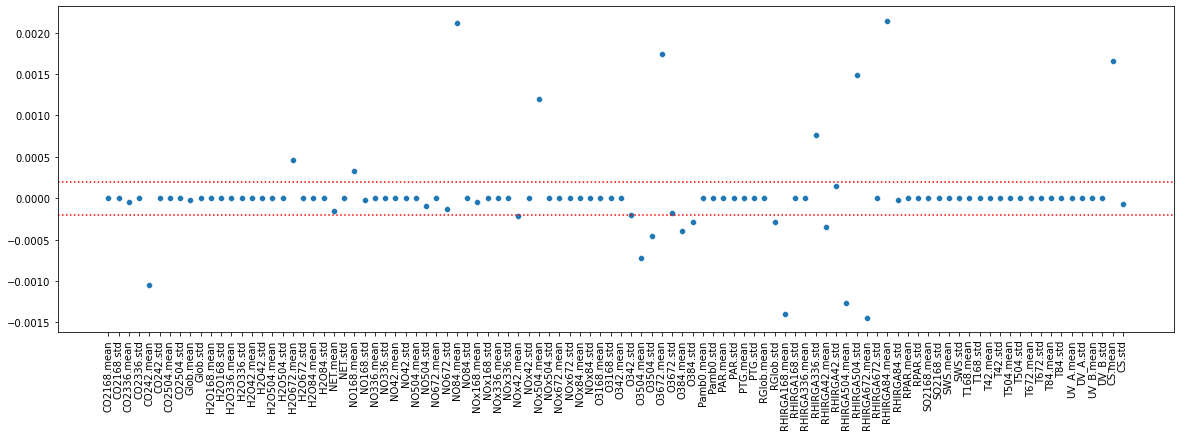

In [146]:
feature_importance_search_c4, selected_features_pi_c4, selected_features_idx_pi_c4 = \
        feature_selection_PI(pipeline_svc_c4_best, X, y_4, 0.0002)

In [159]:
predictor_SVC(X[:, selected_features_idx_pi_c4], y_4)

Best SVC model:  {'clf__C': 1.0, 'clf__degree': 1, 'clf__kernel': 'poly'} 0.6681159420289855
Prediction accuracy:  0.6332367149758454


(HalvingGridSearchCV(cv=10,
                     estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                               ('clf', SVC(random_state=0))]),
                     n_jobs=4,
                     param_grid={'clf__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
        1.e+03, 1.e+04, 1.e+05]),
                                 'clf__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                 'clf__kernel': ['poly', 'rbf', 'sigmoid']}),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', SVC(degree=1, kernel='poly', random_state=0))]),
 array([0.60869565, 0.63043478, 0.52173913, 0.65217391, 0.63043478,
        0.69565217, 0.60869565, 0.69565217, 0.68888889, 0.6       ]))

In [161]:
param_search_gb, pipeline_best_gb, cv_scores_gb = predictor_GBC(X, y_4)

Best GBC model:  {'clf__learning_rate': 0.1, 'clf__n_estimators': 80} 0.642572463768116
Prediction accuracy:  0.6158937198067633


In [92]:
import scipy.spatial

In [136]:
K_mahalanobis = scipy.spatial.distance.squareform(
                    scipy.spatial.distance.pdist(
                        sklearn.preprocessing.StandardScaler().fit_transform(X), metric='mahalanobis'))
#K_js = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X, metric='jensenshannon'))
K_chebyshev = scipy.spatial.distance.squareform(
                    scipy.spatial.distance.pdist(
                        sklearn.preprocessing.StandardScaler().fit_transform(X), metric='chebyshev'))

In [148]:
K_mahalanobis_s = scipy.spatial.distance.squareform(
                    scipy.spatial.distance.pdist(
                        sklearn.preprocessing.StandardScaler().fit_transform(X[:, selected_features_idx_pi_c4]), metric='mahalanobis'))
K_chebyshev_s = scipy.spatial.distance.squareform(
                    scipy.spatial.distance.pdist(
                        sklearn.preprocessing.StandardScaler().fit_transform(X[:, selected_features_idx_pi_c4]), metric='chebyshev'))

In [149]:
K_dict = {'Mahalanobis':K_mahalanobis, 'Chebyshev':K_chebyshev}
K_s_dict = {'Mahalanobis':K_mahalanobis_s, 'Chebyshev':K_chebyshev_s}

In [150]:
predictor_KSVC(K_s_dict, y_4).max()

Kernel         Mahalanobis
C               10000000.0
CV accuracy       0.501235
dtype: object

## Producing answers.csv

In [56]:
test_df = pd.read_csv('./npf_test_hidden.csv')

In [181]:
X_test_df = test_df[X_df.columns].copy()
X_test = test_df[X_df.columns].values
X_test_sel = test_df[selected_features_rfe_rfc_c4].values

In [183]:
X_test_sel_norm = sklearn.preprocessing.StandardScaler().fit_transform(X_test_sel)

In [186]:
# Get class4 prediction using new model: RFECV(RFC) + RFC

pipeline_rf_best_c4_n.fit(X_selected_rfc_c4, y_4)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(criterion='entropy', n_estimators=150,
                                        random_state=0))])

In [193]:
print('class order: ', pipeline_rf_best_c4_n.classes_)
y_4_pred_df = pd.DataFrame(pipeline_rf_best_c4_n.predict_proba(X_test_sel_norm), 
                           columns=['nonevent', 'Ia', 'Ib','II'])

class order:  [0 1 2 3]


In [199]:
y_4_pred_df.loc[:, 'class4_RFC_pred'] = y_4_pred_df.apply(lambda x: y_4_pred_df.columns[np.argmax(x.values)],
                                                          axis=1)

In [212]:
X_test_sel_c2 = test_df[selected_features_rfe_c2].values
X_test_sel_c2_norm = sklearn.preprocessing.StandardScaler().fit_transform(X_test_sel_c2)

In [213]:
# Get class2 envent vs. non-event probability

pipeline_rf_best_c2.fit(X_selected_c2, y_2)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(criterion='entropy', n_estimators=170,
                                        random_state=0))])

In [214]:
print('class order: ', pipeline_rf_best_c2.classes_)
y_2_pred = pipeline_rf_best_c2.predict_proba(X_test_sel_c2_norm)

class order:  [0 1]


In [216]:
y_4_pred_df.loc[:, 'p'] = y_2_pred[:, 1]

In [217]:
# Final raw output for answers.csv

y_4_pred_df

,nonevent,Ia,Ib,II,class4_RFC_pred,p
0,0.186667,0.280000,0.313333,0.220000,Ib,0.523529
1,0.320000,0.253333,0.246667,0.180000,nonevent,0.452941
2,0.186667,0.280000,0.313333,0.220000,Ib,0.517647
3,0.180000,0.280000,0.320000,0.220000,Ib,0.505882
4,0.320000,0.240000,0.206667,0.233333,nonevent,0.423529
...,...,...,...,...,...,...
960,0.173333,0.280000,0.326667,0.220000,Ib,0.494118
961,0.173333,0.306667,0.293333,0.226667,Ia,0.547059
962,0.313333,0.253333,0.246667,0.186667,nonevent,0.482353
963,0.180000,0.280000,0.326667,0.213333,Ib,0.535294


In [218]:
y_4_pred_df.to_csv('raw_answers.csv', index=False)

In [219]:
y_4_pred_df[['class4_RFC_pred', 'p']].to_csv('answers.csv', index=False)